In [87]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [142]:
import pandas as pd 
df_main = pd.read_excel(r"C:\Users\badie\Desktop\coding\nlp case studies\amazon-221126-161000\amazon.xlsx")
df_main = pd.DataFrame(df_main)
df= df_main
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [143]:
# 1. make all letters in lowercase 
df["Review"]=df["Review"].str.lower()
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windows.<br />imag...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i can't believe the qu...


In [144]:
# 2. remove Punctuations
df["Review"]= df["Review"].str.replace('[^\w\s]', '')
df.head(10)

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windowsbr imagery ...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i cant believe the qua...
5,5,0,Not for us,looks different then photo
6,5,0,Perfect for spa room,was exactly what i was looking for heavy mater...
7,5,0,Actually better than expected,looking at the picture i thought these curtain...
8,4,0,Not what expected,much whiter than i thought it would be and was...
9,5,0,Pretty as a Picture,these are curtains just as the picture shows t...


In [145]:
# 3. remove numerical expressions
df["Review"]= df["Review"].str.replace('[\d]', '')
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windowsbr imagery ...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i cant believe the qua...


In [146]:
# 4. remove stopwords
import nltk 
from nltk.corpus import stopwords
sw = stopwords.words('english')
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panels mismatched
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria es que sean un poco mas ...
4,5,0,Wow great purchase,great bang buck cant believe quality material ...


In [147]:
# 5. remove rare words (the less appearing 1000 words)
rare = pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]
rare

keen              1
interpretation    1
greatwould        1
percect           1
nother            1
                 ..
neato             1
decormatches      1
thx               1
pricebrid         1
studioliving      1
Length: 1000, dtype: int64

In [148]:
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in rare))
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panels mismatched
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria es que sean un poco mas ...
4,5,0,Wow great purchase,great bang buck cant believe quality material ...


In [149]:
#6. lemmatization 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.head(50)

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...
4,5,0,Wow great purchase,great bang buck cant believe quality material ...
5,5,0,Not for us,look different photo
6,5,0,Perfect for spa room,exactly looking heavy material great price shi...
7,5,0,Actually better than expected,looking picture thought curtain would thinner ...
8,4,0,Not what expected,much whiter thought would wasnt really expecti...
9,5,0,Pretty as a Picture,curtain picture show rd set ambesonne curtain ...


In [150]:
########  Text Visualization ###############

In [151]:
### word frequency
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

,words,tf
66,curtain,2588.00
42,look,1531.00
120,love,1453.00
104,room,1129.00
166,like,1053.00
...,...,...
2876,unwuiness,1.00
2878,enters,1.00
2879,soonbrlittle,1.00
2880,isbrbrlove,1.00


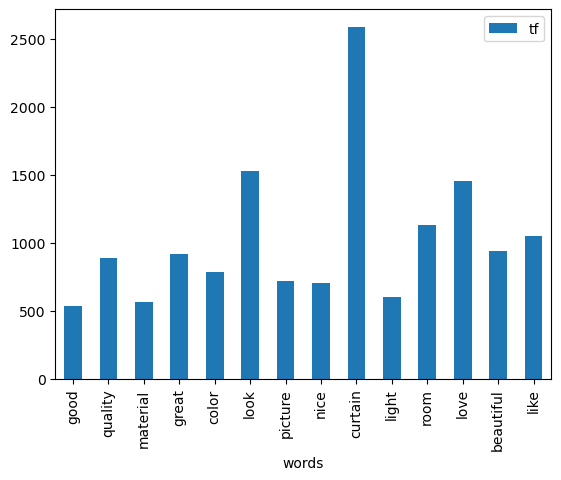

In [152]:
### barplot 
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

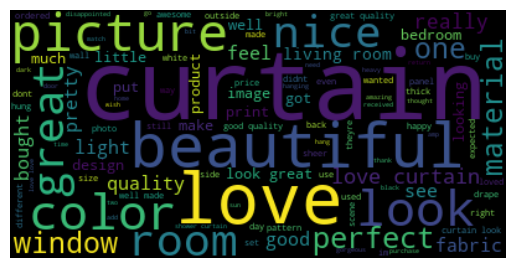

In [153]:
## wordcloud
text = " ".join(i for i in df.Review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [154]:
######## Sentiment Analysis ##########
sia = SentimentIntensityAnalyzer()

In [155]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))


0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [156]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [157]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [158]:
df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head()

,Star,HelpFul,Title,Review,polarity_score,sentiment_label
0,5,0,looks great,happy,0.57,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,0.44,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72,pos
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...,0.00,neg
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,0.90,pos


In [159]:
df["sentiment_label"].value_counts()
df.groupby("sentiment_label")["Star"].mean()


sentiment_label
neg   3.39
pos   4.59
Name: Star, dtype: float64

In [160]:
import sklearn
from sklearn.model_selection import train_test_split
train_x, test_x ,train_y,test_y = train_test_split(df["Review"],
                                                   df["sentiment_label"],
                                                   random_state=42)

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)

In [168]:
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [169]:
##### modeling #####
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

In [170]:
y_pred = log_model.predict(x_test_tf_idf_word)

In [174]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, test_y))


              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



In [175]:
cross_val_score(log_model,x_test_tf_idf_word,test_y,cv=5).mean()

0.8546034570411795

In [180]:
### random review sampling 
from sklearn.feature_extraction.text import CountVectorizer
random_review = pd.Series(df["Review"].sample(1).values)
sample= CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(sample)
print(f"Review: {random_review[0]}   prediction: {pred}")

Review: going buy item say good quality beautiful color mean   prediction: ['pos']


In [181]:
#### random forest 
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word,train_y)

In [184]:
cross_val_score(rf_model,x_test_tf_idf_word,test_y,
               cv=5,
               n_jobs=-1).mean()

0.8916675139806813